# Titanic

## Spis treści
* 1 [Wstęp](#1)
* 2 [Wizualizacja](#2)
	* 2.1 [Uratowani w poszczególnych przedziałach wiekowych](#2_1)
	* 2.2 [Uratowani w poszczególnych klasach](#2_2)
	* 2.3 [Ceny biletów w poszczególnych klasach](#2_3)
* 3 [Uzupełnienie oraz transformacja danych](#3)
	* 3.1 [Skalowanie oraz uzupełnienie cen biletów](#3_1)
	* 3.2 [Uzupełnienie danych o zaokrętowaniu](#3_2)
	* 3.3 [Utworzenie współczynnika przetrwania osób dla biletu](#3_3)
	* 3.4 [Wyodrębnienie tytułu](#3_4)
	* 3.5 [Uzupełnienie danych o wieku](#3_5)
	* 3.6 [Dodanie kolumny informującej o posiadaniu dziecka](#3_6)
	* 3.7 [Skrócenie identyfikatorów kabiny oraz biletu](#3_7)
	* 3.8 [Zamiana danych tekstowych na dane kategoryczne](#3_8)
* 4 [Uczenie](#4_1)
	* 4.1 [Test modeli](#4_1)
	* 4.2 [Wybór liczby kolumn](#4_2)
	* 4.3 [Tuning modelu](#4_3)
	* 4.4 [Interpretacja modelu](#4_4)
* 5 [Wynik](#5)

<a id='1'></a>
## 1. Wstęp
Jedna z największych katastrof statku stała się także inspiracją dla jednego z najpopularniejszych konkursów na temat danych. Podczas tworzenia analizy przyświecały mi dwa cele. Pierwszym z nich było stworzenie modelu, który jak najlepiej przewiduje czy dana osoba przetrwała katastrofę. Drugim natomiast zbadanie, jakie czynniki miały największy wpływ na przetrwanie. <br>
Dane użyte podczas analizy pochodzą z konkursu [kaggle](https://www.kaggle.com/c/titanic/).<br>
Zawierają one następujące kolumny:<br>
1. **Age**- wiek;<br>
2. **Cabin**- kabina;<br>
3. **Embarked**- port na którym dana osoba wsiadła na statek.<br> &nbsp;&nbsp;&nbsp;&nbsp;Titanic odwiedził trzy porty Southampton (S) Cherbourg (C) Queenstown (Q);<br>
4. **Fare** - opłata za bilet;<br>
5. **Name** - imię i nazwisko;<br>
6. **Parch** - liczba dzieci;<br>
7. **Pclass** - klasa;<br>
8. **Sex** - płeć;<br>
9. **SibSp** - liczba rodzeństwa;<br>
10. **Survived** - czy dana osoba przetrwała kolumna uzpułeniona dla danych treningowych a przewidywana dla testowych;<br>
11. **Ticket** - identyfikator biletu;<br>

In [1]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv('../input/titanic_train.csv', index_col=0)
df_test = pd.read_csv('../input/titanic_test.csv', index_col=0)
df = pd.concat([df_train, df_test])

In [3]:
df_train.shape,df_test.shape,df.shape

((891, 11), (418, 10), (1309, 11))

In [4]:
pandas_profiling.ProfileReport(df)

Number of variables,12
Number of observations,1309
Total Missing (%),10.8%
Total size in memory,122.8 KiB
Average record size in memory,96.1 B
Numeric,7
Categorical,5
Boolean,0
Date,0
Text (Unique),0
Rejected,0


<a id='2'></a>
## 2. Wizualizacja

In [5]:
def plot_texts(title=None, xlabel=None, ylabel=None, legend=None):
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

In [6]:
def hide_spines_and_ticks(ax):
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.yticks([])
    plt.xticks([])
    ax.set_facecolor('white')


def add_column(ax,
               colors,
               position,
               title,
               values,
               ha='right',
               x_positions=None,
               y_positions=None):
    plt.text(position, -.6, title, ha=ha, color='grey', fontsize=14)
    for i, e in enumerate(values):
        x_pos = x_positions[i] if x_positions else position
        y_pos = y_positions[i] if y_positions else i
        ax.text(
            x_pos, y_pos, e, fontsize=12, va='center', ha=ha, color=colors[i])


def set_colors(ax, colors, bars):
    for i in range(len(bars)):
        bars[i].set_color(colors[i])
    ax.tick_params(axis='x', colors='grey')


def bar_plot(data, colors, figsize=None):
    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots()
    bars = ax.barh(range(len(data)), data)
    ax.invert_yaxis()
    return fig, ax, bars


def get_zip_data(data):
    x = []
    for e in zip(*data):
        x.extend(list(e))
    return x


def add_legend(ax, colors, labels):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    colors_and_labels = [
        (cmap(e), labels[i])
        for i, e in enumerate(np.linspace(0, .99, len(labels)))
    ]
    legend_TN = [
        mpatches.Patch(color=c, label=l, edgecolor='black')
        for c, l in colors_and_labels
    ]
    legend = ax.legend(
        loc='center left',
        bbox_to_anchor=(.45, 0.85),
        handles=legend_TN,
        frameon=False)

In [7]:
bins = list(range(0, 70, 10)) + [120]

In [8]:
def group_by_sex_and_age(df_train, bins):
    size = len(bins) - 1
    d_all = {'female': np.zeros(size), 'male': np.zeros(size)}
    group_all = df_train.groupby(['Sex', pd.cut(df_train.Age, bins)], )
    for i, e in group_all.Name.count().iteritems():
        d_all[i[0]][i[1].left // 10] = e
    d_survived = {'female': np.zeros(7), 'male': np.zeros(7)}
    survived = df_train.query('Survived == 1')
    for i, e in survived.groupby(
        ['Sex', pd.cut(survived.Age, bins)], ).Name.count().iteritems():
        d_survived[i[0]][i[1].left // 10] = e
    x = get_zip_data([
        list(d_survived['female'] / d_all['female']),
        list(d_survived['male'] / d_all['male'])
    ])
    x_count = get_zip_data(
        [list(d_survived['female']),
         list(d_survived['male'])])
    return x, x_count


bins = list(range(0, 70, 10)) + [120]
x, x_count = group_by_sex_and_age(df_train, bins)

In [9]:
bins_labels = []
for e in bins[:-2]:
    bins_labels.append('od %d do %d' % (e + 1, e + 10))
bins_labels.append('powyżej %d' % bins[-2])

<a id='2_1'></a>
### 2.1 Uratowani w poszczególnych przedziałach wiekowych

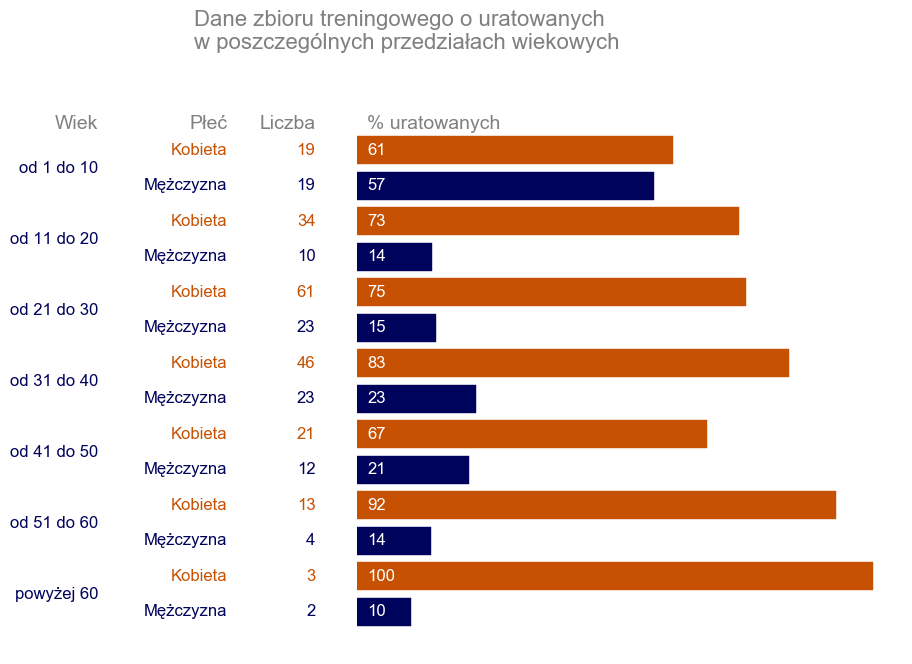

In [10]:
colors_ = ['xkcd:dark orange', 'xkcd:dark blue'] * (len(x) // 2)
fig, ax, bars = bar_plot(x, colors_, (7, 7))
set_colors(ax, colors_, bars)
add_column(ax, ['xkcd:dark blue'] * len(bins_labels),-.5,'Wiek',bins_labels,
                y_positions=list(np.arange(.5, 14.5, 2)))
add_column(ax, colors_, -.25, 'Płeć', ['Kobieta', 'Mężczyzna'] * (len(x_count) // 2))
add_column(ax, ['white'] * len(x_count),.02,'% uratowanych', ['%d' % (e * 100) for e in x],ha='left')
add_column(ax, colors_, -.08, 'Liczba', [int(e) for e in x_count])
plt.title('Dane zbioru treningowego o uratowanych\nw poszczególnych przedziałach wiekowych',
            color='grey',size=16,x=-0.3,y=1.1,ha='left')
hide_spines_and_ticks(ax)

In [11]:
def group_by_sex_and_age(df_train):
    d_all = {'female': np.zeros(3), 'male': np.zeros(3)}
    group_all = df_train.groupby(['Pclass', 'Sex'])
    for i, e in group_all.Name.count().iteritems():
        d_all[i[1]][i[0] - 1] = e
    d_survived = {'female': np.zeros(3), 'male': np.zeros(3)}
    survived = df_train.query('Survived == 1')
    for i, e in survived.groupby(['Pclass', 'Sex']).Name.count().iteritems():
        d_survived[i[1]][i[0] - 1] = e
    x = get_zip_data([
        list(d_survived['female'] / d_all['female']),
        list(d_survived['male'] / d_all['male'])
    ])
    x_count = get_zip_data(
        [list(d_survived['female']),
         list(d_survived['male'])])
    return x, x_count

<a id='2_2'></a>
### 2.2 Uratowani w poszczególnych klasach

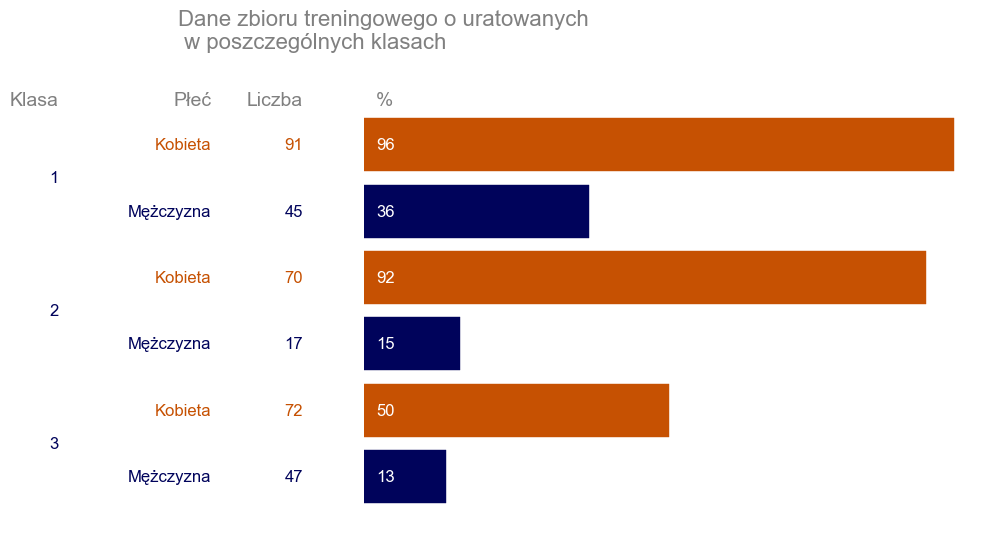

In [12]:
x, x_count = group_by_sex_and_age(df_train)
colors_ = ['xkcd:dark orange', 'xkcd:dark blue'] * (len(x) // 2)
fig, ax, bars = bar_plot(x, colors_)
set_colors(ax, colors_, bars)
add_column(
    ax, ['xkcd:dark blue'] * 3,
    -.5,
    'Klasa', [1, 2, 3],
    y_positions=list(np.arange(.5, 5.5, 2)))
add_column(ax, colors_, -.25, 'Płeć', ['Kobieta', 'Mężczyzna'] * 3)
add_column(
    ax, ['white'] * len(x_count),
    .02,
    '%', ['%d' % (e * 100) for e in x],
    ha='left')
add_column(ax, colors_, -.1, 'Liczba', [int(e) for e in x_count])
plt.title(
    'Dane zbioru treningowego o uratowanych\n w poszczególnych klasach',
    color='grey',
    size=16,
    x=-0.3,
    y=1.1,
    ha='left')
hide_spines_and_ticks(ax)

<a id='2_3'></a>
### 2.3 Ceny biletów w poszczególnych klasach

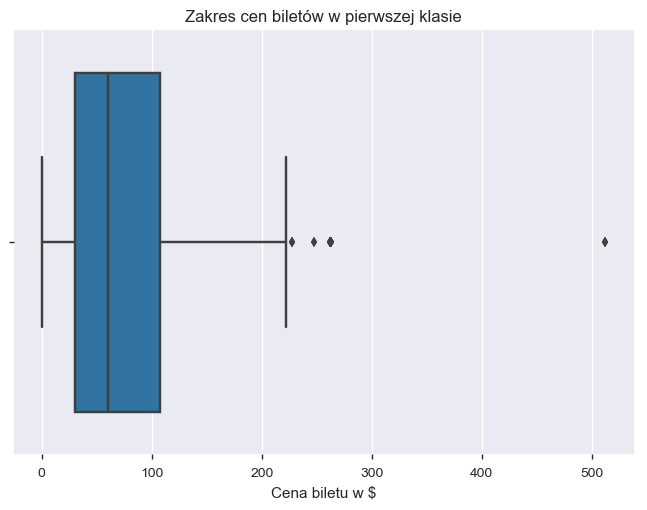

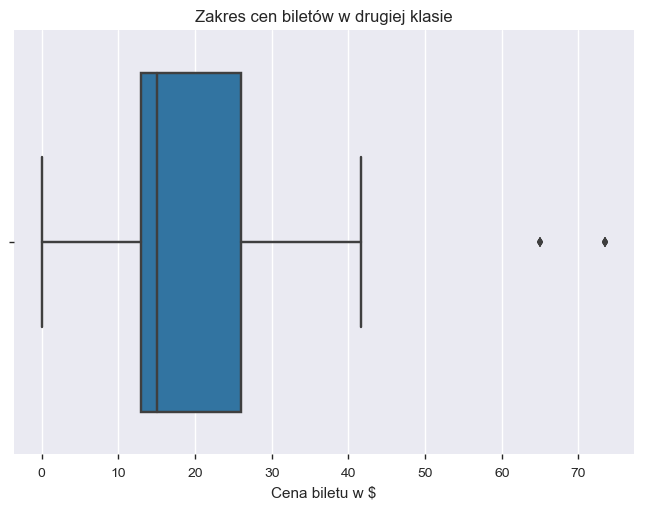

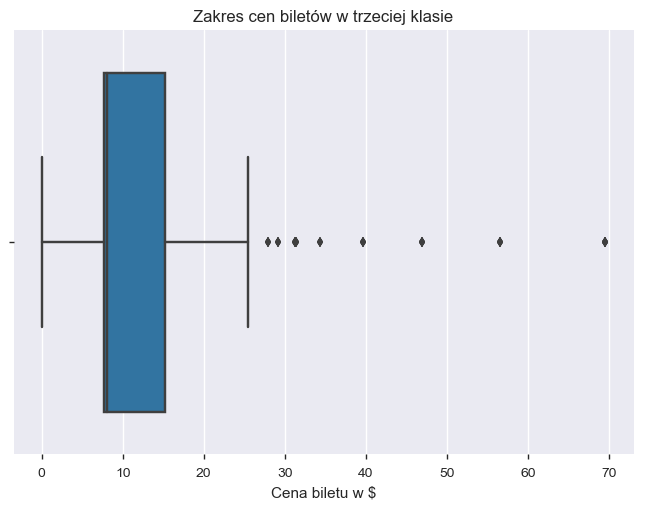

In [13]:
txt = 'pierwszej drugiej trzeciej'.split()
for i in range(1, 4):
    plt.figure()
    sns.boxplot(df.query('Pclass == %d' % i).Fare.dropna())
    plot_texts(
        title='Zakres cen biletów w %s klasie' % txt[i - 1],
        xlabel='Cena biletu w $')

In [14]:
df.groupby('Pclass').Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,87.508992,80.447178,0.0,30.6958,60.0000,107.6625,512.3292
2,277.0,21.179196,13.607122,0.0,13.0000,15.0458,26.0000,73.5000
3,708.0,13.302889,11.494358,0.0,7.7500,8.0500,15.2458,69.5500


<a id='3'></a>
# 3. Uzupełnienie oraz transformacja danych

<a id='3_1'></a>
### 3.1 Skalowanie oraz uzupełnienie cen biletów

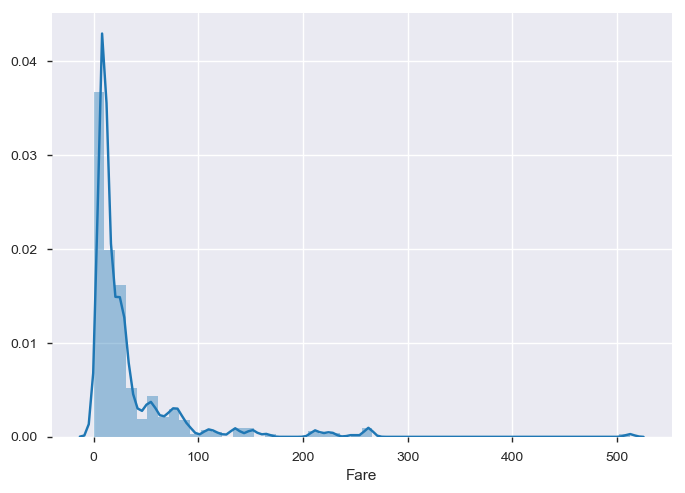

In [15]:
sns.distplot(df.Fare.dropna())

In [16]:
df.Fare = df.Fare.apply(lambda x: np.log(x + 9))

In [17]:
sum(df.Fare.isna())

1

In [18]:
df.Fare.fillna(df.Fare.median(), inplace=True)

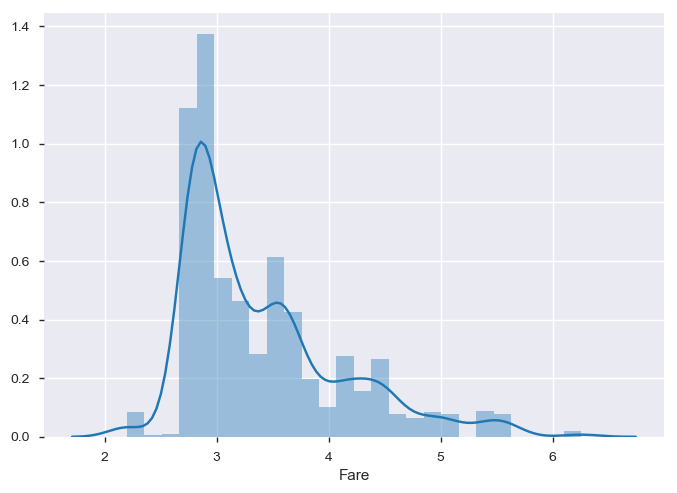

In [19]:
sns.distplot(df.Fare)

Aby zmniejszyć wpływ wartości skrajnych oraz zwiększyć ciągłość danych zastosowano przekształcenie logarytmiczne. Użyto także mediany dla uzupełnienia brakującej wartości. 

<a id='3_2'></a>
### 3.2 Uzupełnienie danych o zaokrętowaniu

In [20]:
sum(df.Embarked.isna())

2

In [21]:
print(df_train.groupby('Embarked').Embarked.count())
df.Embarked.fillna('S', inplace=True)

Embarked
C    168
Q     77
S    644
Name: Embarked, dtype: int64


Uzupełnienie najczęściej występującą wartością brakujących danych w kolumnie port. 

<a id='3_3'></a>
### 3.3 Utworzenie współczynnika przetrwania osób dla biletu

In [22]:
count = df_train.groupby('Ticket').Ticket.count().iteritems()
survived = df_train.groupby('Ticket').Survived.sum().iteritems()
for c, s in zip(count, survived):
    if c[1] > 1:
        df.loc[df['Ticket'] == c[0], 'TicketSurvivalRatio'] = s[1] / c[1]
df.TicketSurvivalRatio.fillna(0.5, inplace=True)

Współczynnik przetrwania biletu opisuje stosunek liczby osób, które przetrwały do wszystkich podróżujących na danym bilecie.

<a id='3_4'></a>
### 3.4 Wyodrębnienie tytułu

In [23]:
def get_title(x):
    for e in x.split():
        if e.endswith('.'):
            return e[:-1]
    return 'Other'


df['Title'] = df.Name.apply(get_title)

Text(0.5,1,'Liczba osób o danym tytule')

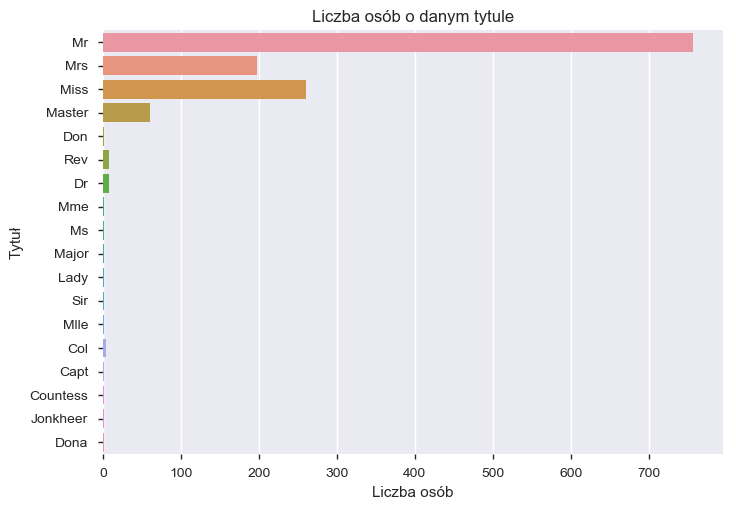

In [24]:
sns.countplot(y=df.Title)
plt.xlabel('Liczba osób')
plt.ylabel('Tytuł')
plt.title('Liczba osób o danym tytule')

<a id='3_5'></a>
### 3.5 Uzupełnienie danych o wieku

In [25]:
sum(df.Age.isna())

263

In [26]:
df.Age = df.groupby(
    ['Title', 'Sex', 'Embarked',
     'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
df.Age.fillna(df.Age.median(), inplace=True)

Dane zostały uzupełnione medianą wieku. Mediana była liczona dla osób o tym samym tytule, płci, płynących w tej samej klasie oraz zaokrętowanych w tym samym porcie, co osoba z brakującym wiekiem. 

<a id='3_6'></a>
### 3.6 Dodanie kolumny informującej o posiadaniu dziecka

In [27]:
df.Parch = df.Parch.apply(lambda x: 3 if x > 2 else x)
df['HaveChild'] = df.Parch.apply(lambda x: 0 if x == 0 else 1)

Na podstawie informacji o posiadanej liczbie dzieci, została dodana binarna kolumna informująca, czy dana osoba ma dziecko. 

<a id='3_7'></a>
### 3.7 Skrócenie identyfikatorów kabiny oraz biletu 

In [28]:
df.Cabin = df.Cabin.fillna('N').apply(lambda x: x[:2])

In [29]:
df.Ticket = df.Ticket.apply(lambda x: x[:2])

<a id='3_8'></a>
### 3.8 Zamiana danych tekstowych na dane kategoryczne

In [30]:
df = pd.get_dummies(df.drop(['Name'], axis=1), drop_first=True)
df.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,TicketSurvivalRatio,HaveChild,Cabin_A2,Cabin_A3,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,2.788093,0,3,1,0.0,0.5,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,38.0,4.385562,0,1,1,1.0,0.5,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,26.0,2.828792,0,3,0,1.0,0.5,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,35.0,4.128746,0,1,1,1.0,0.5,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,35.0,2.836150,0,3,0,0.0,0.5,0,0,0,...,0,0,0,0,0,1,0,0,0,0


<a id='4'></a>
## 4. Uczenie

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, \
    Ridge, Lasso,SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [32]:
train = df[df.Survived.notna()]
X = train.drop('Survived', axis=1)
y = train.Survived

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [34]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
def get_models():
    return [
        LinearRegression(),
        LogisticRegression(),
        Ridge(),
        Lasso(),
        RandomForestRegressor(),
        XGBRegressor(),
        SVR(),
        SGDRegressor(),
    ]

In [36]:
def test(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    #print(type(model).__name__,metrics.accuracy_score(y_test,y_pred))
    return metrics.auc(fpr, tpr), type(model).__name__, fpr, tpr

<a id='4_1'></a>
### 4.1 Test modeli

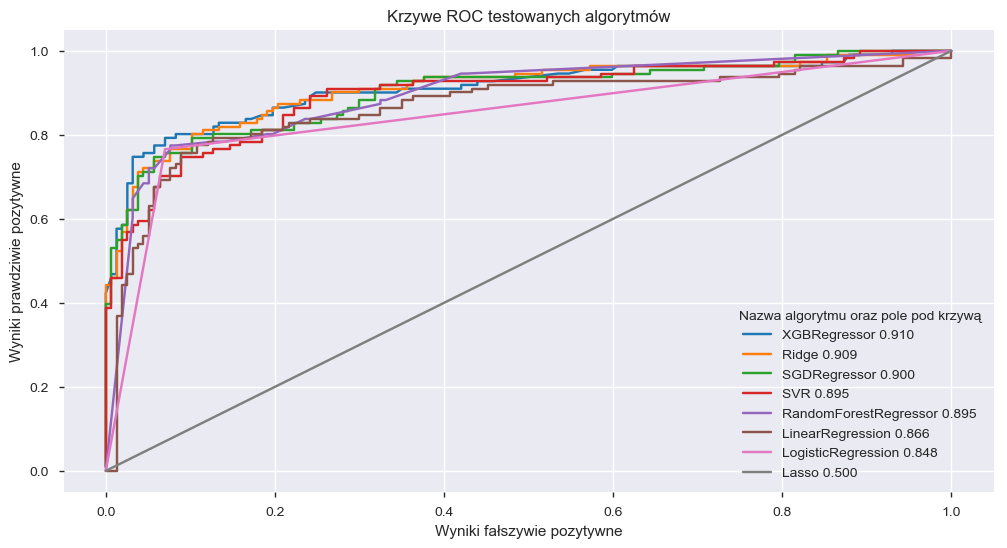

In [37]:
l = []
plt.figure(figsize=(12, 6))
# poly = PolynomialFeatures(2)
# X_poly = poly.fit_transform(X_train)
for m in get_models():
    tmp = test(m, X_train, X_test, y_train, y_test)
    l.append(tmp)
for r in sorted(l, reverse=True):
    plt.plot(r[2], r[3], label='%s %.3f' % (r[1], r[0]))
plot_texts(
    title='Krzywe ROC testowanych algorytmów',
    ylabel='Wyniki prawdziwie pozytywne',
    xlabel='Wyniki fałszywie pozytywne')
plt.legend(
    title='Nazwa algorytmu oraz pole pod krzywą', loc='lower right')

Dwa najwyższe wyniki uzyskały modele XGBRegressor oraz Ridge. Ze względu na większą prostotę, do dalszej optymalizacji został wybrany model Ridge.

<a id='4_2'></a>
### 4.2 Wybór liczby kolumn

100%|██████████| 135/135 [00:31<00:00,  4.27it/s]


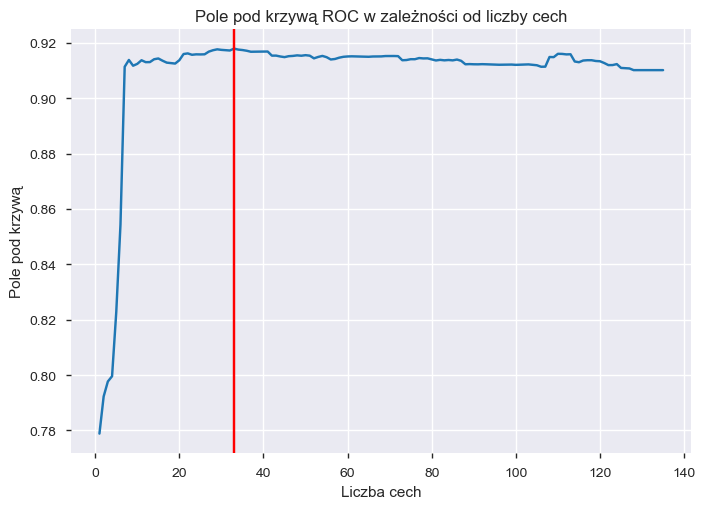

In [38]:
l = []
scoring = metrics.make_scorer(metrics.roc_auc_score)
for i in tqdm(range(len(X.columns), 0, -1)):
    select = SelectKBest(chi2, k=i)
    X_new = select.fit_transform(X, y)
    reg = Ridge()
    l.append((i,
              np.mean(
                  cross_val_score(reg, X_new, y, scoring=scoring, n_jobs=-1))))
    #print(l[-1])
x_, y_ = zip(*l)
plt.plot(x_, y_)
how_many_features = x_[y_.index(max(y_))]
plt.axvline(
    how_many_features, color='red', label='Optymalna liczba cech')
plot_texts(
    title='Pole pod krzywą ROC w zależności od liczby cech',
    ylabel='Pole pod krzywą',
    xlabel='Liczba cech')

In [39]:
how_many_features

33

Najlepszy wynik zostaje uzyskany dla 33 cech. Już kilkanaście najbardziej wartościowych cech zawiera większość informacji, potrzebnych do klasyfikacji. 

<a id='4_3'></a>
### 4.3 Tuning modelu

In [40]:
select = SelectKBest(chi2, k=how_many_features)
X_new = select.fit_transform(X, y)
reg = Ridge(random_state=42)
params = {
    'alpha': [0, 1e-20, 1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
scoring = metrics.make_scorer(metrics.roc_auc_score)
grid = GridSearchCV(
    reg, params, return_train_score=True, scoring=scoring, cv=5, n_jobs=-1)
grid.fit(X_new, y)
pd.DataFrame(grid.cv_results_).sort_values(
    'mean_test_score', ascending=False).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_solver,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
52,0.101306,0.002968,0.918041,0.929348,0.01,lsqr,"{'solver': 'lsqr', 'alpha': 0.01}",1,0.921398,0.928929,...,0.914573,0.928051,0.911098,0.928121,0.946239,0.925243,0.040509,0.002611,0.016205,0.003739
59,0.030456,0.002167,0.917983,0.928484,1,lsqr,"{'solver': 'lsqr', 'alpha': 1}",2,0.921186,0.928122,...,0.914838,0.927656,0.912539,0.926808,0.944582,0.923827,0.013131,0.000841,0.015535,0.004048
3,0.042732,0.001572,0.917978,0.929355,0,lsqr,"{'solver': 'lsqr', 'alpha': 0}",3,0.921469,0.928941,...,0.914573,0.928055,0.910967,0.928129,0.946239,0.925239,0.006159,0.000053,0.016286,0.003743
10,0.044051,0.002423,0.917978,0.929355,1e-20,lsqr,"{'solver': 'lsqr', 'alpha': 1e-20}",3,0.921469,0.928941,...,0.914573,0.928055,0.910967,0.928129,0.946239,0.925239,0.010409,0.001564,0.016286,0.003743
45,0.039295,0.002102,0.917964,0.929354,0.001,lsqr,"{'solver': 'lsqr', 'alpha': 0.001}",5,0.921398,0.928941,...,0.914573,0.928055,0.910967,0.928121,0.946239,0.925239,0.018386,0.000819,0.016283,0.003745


In [41]:
grid.best_params_

{'alpha': 0.01, 'solver': 'lsqr'}

<a id='4_4'></a>
### 4.4 Interpretacja modelu

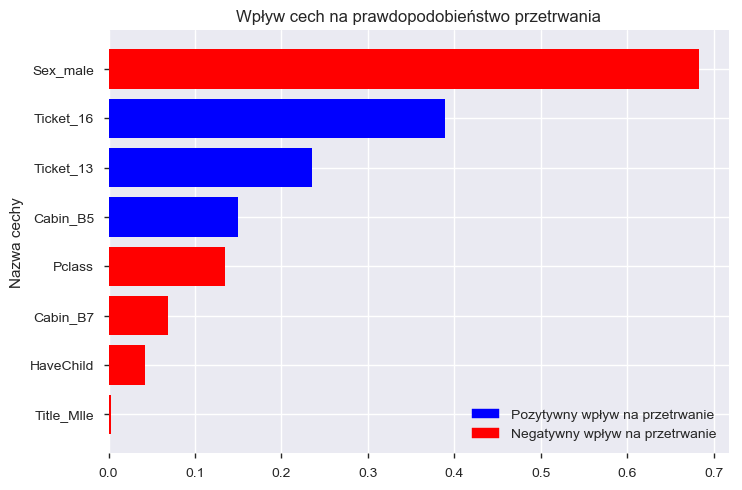

In [42]:
select = SelectKBest(chi2, k=how_many_features)
X_new = select.fit_transform(X_train, y_train)
reg = grid.best_estimator_
reg.fit(X_new, y_train)
sort_key = lambda x: x[0] if x[0] >= 0 else -x[0]
names = np.array(X.columns)[select.get_support()]
best = [(c, n) for c, n, s in zip(reg.coef_, names, select.pvalues_)
        if s <= 0.05]
coef, names = zip(*sorted(best, key=sort_key, reverse=True))
colors = ['red' if x < 0 else 'blue' for x in coef]
coef = [abs(x) for x in coef]
loc = list(range(len(coef)))

fig, ax = plt.subplots()
plt.barh(loc, coef, color=colors)
ax.invert_yaxis()
plt.yticks(loc, names, rotation='horizontal')
blue_patch = mpatches.Patch(
    color='blue', label='Pozytywny wpływ na przetrwanie')
red_patch = mpatches.Patch(color='red', label='Negatywny wpływ na przetrwanie')
plt.legend(
    handles=[blue_patch, red_patch], loc='lower right')
plot_texts(
    title='Wpływ cech na prawdopodobieństwo przetrwania', ylabel='Nazwa cechy')
y_pred = reg.predict(select.transform(X_test))
#y_pred=[1 if e1>=0.5 else 0 for e1 in y_pred]
#metrics.roc_auc_score(y_test,y_pred)

Największy wpływ na przetrwanie miały płeć, klasa oraz to, czy dana osoba posiada dzieci. Podczas ewakuacji obowiązywała zasada "kobiety i dzieci najpierw". Warto także zauważyć, że duża część osób płci męskiej, która została uratowana, była poniżej 10 roku życia. Podróż w niższej klasie, także miała negatywny wpływ na przetrwanie. Warto tutaj zauważyć, że najniższa klasa, była także najliczniejsza. Również osoby posiadające dzieci, miały mniejsze szanse na przetrwanie. Łatwo sobie wyobrazić, że w wypadku gdy brakowało miejsc, ludzie starali się przynajmniej umieścić dzieci w szalupie.

<a id='5'></a>
## 5. Wynik

In [43]:
df.Fare.fillna(df.Fare.median(), inplace=True)
select = SelectKBest(chi2, k=how_many_features)
X_new = select.fit_transform(X, y)
reg = grid.best_estimator_
reg.fit(X_new, y)
df_test = df[df.Survived.isna()]
y_pred = reg.predict(select.transform(df_test.drop('Survived', axis=1)))
df_test['Survived'] = [1 if e1 >= 0.5 else 0 for e1 in y_pred]
df_test[['Survived']].to_csv('prediction.csv')

![Ranking](pictures/titanic_rank.png)
Top 5% rozwiązań kaggle. Rozwiązanie to pokonuje ponad 9 tysięcy innych uczestników. 